In [6]:
# Import packages
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.plotting import plot_decision_regions
import pickle
%matplotlib inline
# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Class balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline

#Modeling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Yellowbrick visuals-- used for model selection + metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix

Using TensorFlow backend.


In [134]:
df = pd.read_csv('/Users/alentersakyan/Desktop/Project_3/Marketing.csv')
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,20,1,0,0,0,0,0,3,11,0


## Pandas profile report for EDA

In [135]:
#pd.read_csv('/Users/alentersakyan/Desktop/Project_3/Marketing.csv').profile_report()

# Cleaning + Further EDA

## Get age

In [136]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [1]:
df.columns

NameError: name 'df' is not defined

In [138]:
# Get age from dob
def getage(year_birth_col):
    return pd.to_datetime('2015-01').year - year_birth_col

In [139]:
df['Age'] = df['Year_Birth'].apply(getage)

In [140]:
df.Age.describe()

count    2240.000000
mean       46.194196
std        11.984069
min        19.000000
25%        38.000000
50%        45.000000
75%        56.000000
max       122.000000
Name: Age, dtype: float64

# Examine AcceptedCmp_ features
- Who are the people that did not accept any 1-5 offers, most likely did not accept the recent one? (0)

In [141]:
df[df['AcceptedCmp1'] == 1].describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
count,144.000000,144.000000,142.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.0,144.000000,144.0,144.000000,144.000000
mean,5324.493056,1968.534722,78872.626761,0.090278,0.215278,46.979167,758.604167,55.847222,433.638889,91.861111,...,8.062500,3.534722,0.166667,0.326389,0.472222,1.0,0.090278,0.0,0.548611,46.465278
std,3078.326355,13.530547,11337.015726,0.332677,0.445069,28.380647,333.571922,55.342079,263.292935,73.293892,...,2.699958,2.044653,0.373979,0.470528,0.500970,0.0,0.287580,0.0,0.499368,13.530547
min,146.000000,1944.000000,37929.000000,0.000000,0.000000,1.000000,152.000000,0.000000,21.000000,0.000000,...,4.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,21.000000
25%,2793.750000,1957.000000,73065.000000,0.000000,0.000000,25.000000,502.000000,19.750000,196.000000,32.000000,...,6.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,36.000000
50%,4901.500000,1969.500000,79967.000000,0.000000,0.000000,45.500000,761.500000,29.500000,437.500000,76.000000,...,8.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,1.000000,45.500000
75%,7896.750000,1979.000000,85663.750000,0.000000,0.000000,71.250000,1006.750000,87.750000,614.750000,146.250000,...,10.000000,5.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.0,1.000000,58.000000
max,10965.000000,1994.000000,105471.000000,2.000000,2.000000,99.000000,1493.000000,190.000000,974.000000,253.000000,...,13.000000,9.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.0,1.000000,71.000000


# Create feature for total number of offers used (1-5) before the current

In [152]:
df['total_accepted_offers'] = df.AcceptedCmp1 + df.AcceptedCmp2 + df.AcceptedCmp3 + df.AcceptedCmp4 + df.AcceptedCmp5

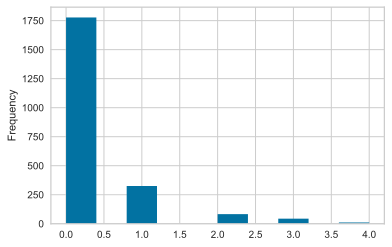

In [157]:
df['total_accepted_offers'].plot(kind='hist')

# Examine NumDealsPurchase + Purchase by location

In [143]:
df['NumDealsPurchases'].describe()

count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64

In [144]:
df['NumWebPurchases'].describe()

count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64

In [145]:
df['NumCatalogPurchases'].describe()

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64

In [146]:
df['NumStorePurchases'].describe()

count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64

# Web traffic flow

In [147]:
df['NumWebVisitsMonth'].describe()

count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64

In [148]:
x = df.groupby('NumWebVisitsMonth')

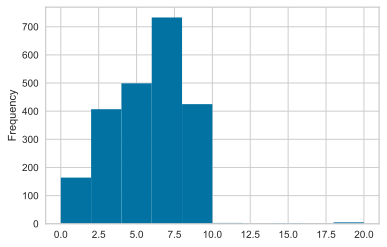

In [149]:
df.NumWebVisitsMonth.plot(kind='hist', bins=10)

### We can see that there are very few 10+ web visits so I will combine 10+ into one

In [150]:
df[df.NumWebVisitsMonth >= 10]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,0,20,1,0,0,0,0,0,0,65
47,7286,1968,Graduation,Together,41728.0,1,0,2013-05-24,92,13,...,2,10,0,0,0,0,0,0,0,47
605,7141,1986,Master,Single,21888.0,1,0,2012-12-29,15,88,...,2,10,0,0,0,0,0,0,1,29
774,4303,1957,PhD,Together,6835.0,0,1,2012-12-08,76,107,...,1,20,0,0,0,0,0,0,0,58
981,3955,1965,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,...,0,14,0,0,0,0,0,0,0,50
1042,10749,1991,Graduation,Single,8028.0,0,0,2012-09-18,62,73,...,0,19,0,0,0,0,0,0,0,24
1245,6862,1971,Graduation,Divorced,1730.0,0,0,2014-05-18,65,1,...,0,20,0,0,0,0,0,0,0,44
1328,4246,1982,Master,Single,6560.0,0,0,2013-12-12,2,67,...,1,17,0,0,0,0,0,0,0,33
1524,11110,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,...,0,14,0,0,0,0,0,0,0,42
1846,9931,1963,PhD,Married,4023.0,1,1,2014-06-23,29,5,...,0,19,0,0,0,0,0,0,0,52


In [151]:
df['NumWebVisitsMonth'] 

0       7
1       5
2       4
3       6
4       5
       ..
2235    5
2236    7
2237    6
2238    3
2239    7
Name: NumWebVisitsMonth, Length: 2240, dtype: int64

## Remove excess features

In [158]:
# df_reduced = df['Education', 'Marital_Status', 'Income', 'Kidhome',
#        'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
#        'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
#        'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
#        'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Complain', 'Response']

df.drop(['ID', 'Year_Birth'], axis=1, inplace=True)
# df.drop(['ID', 'Year_Birth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2'], axis=1, inplace=True)




In [159]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'total_accepted_offers'],
      dtype='object')

In [160]:
#df.profile_report()

### Education Cleaning

In [161]:
df['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [162]:
df['Education'].rename({"2n Cycle": "HigherEd", "Master": "HigherEd", "PhD": "HigherEd"},inplace=True)

In [163]:
edu_dict = {'HigherEd': ['2n Cycle', 'Master', 'PhD']}
dict2 = {i : k for k, v in edu_dict.items() for i in v}

In [164]:
dict2

{'2n Cycle': 'HigherEd', 'Master': 'HigherEd', 'PhD': 'HigherEd'}

In [165]:
df['Education'].replace(dict2, inplace=True)

In [166]:
# Education dummy
df = pd.get_dummies(df, columns=['Education'], drop_first = True)

### Income Cleaning

In [167]:
df['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [168]:
df = df[df['Income'] < 400000]

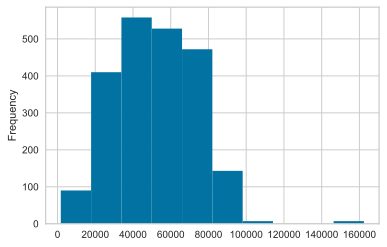

In [169]:
df['Income'].plot(kind='hist')

In [170]:
df['Income'].fillna(df['Income'].median())

0       58138.0
1       46344.0
2       71613.0
3       26646.0
4       58293.0
         ...   
2235    61223.0
2236    64014.0
2237    56981.0
2238    69245.0
2239    52869.0
Name: Income, Length: 2215, dtype: float64

### Kid at home Cleaning

In [171]:
df['Kidhome'].value_counts()

0    1283
1     886
2      46
Name: Kidhome, dtype: int64

In [172]:
df['Kidhome'].replace(2,1,inplace=True)

### Marital Status

In [173]:
df['Marital_Status'].value_counts()

Married     857
Together    572
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [174]:
df['Marital_Status'].replace('Alone', 'Single', inplace=True)

In [175]:
df['Marital_Status'].replace('YOLO', 'Single', inplace=True)

In [176]:
df['Marital_Status'].replace('Absurd', 'Single', inplace=True)

In [177]:
df['Marital_Status'].replace('Divorced', 'OnceMarried', inplace=True)
df['Marital_Status'].replace('Widow', 'OnceMarried', inplace=True)

In [178]:
# Get dummies, drop first (married)... Make sure to be clear on this interpretation later..
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first = True)

### Teen at home

In [179]:
df['Teenhome'].value_counts()

0    1146
1    1018
2      51
Name: Teenhome, dtype: int64

In [180]:
df['Teenhome'].replace(2,1,inplace=True)

### Amt Purchased

In [181]:
df.MntWines.describe()

count    2215.000000
mean      305.225282
std       337.345380
min         0.000000
25%        24.000000
50%       175.000000
75%       505.000000
max      1493.000000
Name: MntWines, dtype: float64

In [182]:
df.MntFishProducts.describe()

count    2215.000000
mean       37.651016
std        54.760822
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishProducts, dtype: float64

In [183]:
df.MntFruits.describe()

count    2215.000000
mean       26.361625
std        39.802036
min         0.000000
25%         2.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64

In [184]:
df.MntMeatProducts.describe()

count    2215.000000
mean      167.063205
std       224.311559
min         0.000000
25%        16.000000
50%        68.000000
75%       232.500000
max      1725.000000
Name: MntMeatProducts, dtype: float64

In [185]:
df.MntSweetProducts.describe()

count    2215.000000
mean       27.040632
std        41.077594
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       262.000000
Name: MntSweetProducts, dtype: float64

In [186]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together'],
      dtype='object')

### Date they became a customer-- translate to years since today

In [187]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer)

In [188]:
df.Dt_Customer

0      2012-09-04
1      2014-03-08
2      2013-08-21
3      2014-02-10
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-06-10
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2215, dtype: datetime64[ns]

In [189]:
# Get length of being a customer (from dt_customer - 2015-01)
def getCustomerLength(customer_length_col):
    return pd.to_datetime('2015-01') - customer_length_col

In [190]:
df['CustomerLength'] = df['Dt_Customer'].apply(getCustomerLength)

In [191]:
df['CustomerLength'].describe()

count                        2215
mean     539 days 12:05:31.557562
std      202 days 11:29:22.020159
min             186 days 00:00:00
25%             366 days 00:00:00
50%             541 days 00:00:00
75%             715 days 00:00:00
max             885 days 00:00:00
Name: CustomerLength, dtype: object

In [192]:
type(pd.to_datetime('today'))

pandas._libs.tslibs.timestamps.Timestamp

In [193]:
import datetime as dt

In [194]:
df['CustomerLength'] = df['CustomerLength'].dt.days

## Compute variable for total revenue in last 2 years

In [195]:
df['TotalRevenueFoodItems'] = df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

In [196]:
df['TotalRevenueFoodItems']

0       1529
1         21
2        734
3         48
4        407
        ... 
2235    1094
2236     436
2237    1217
2238     782
2239     151
Name: TotalRevenueFoodItems, Length: 2215, dtype: int64

# Final exploration before pickle/model

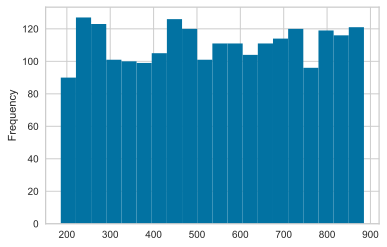

In [198]:
df['CustomerLength'].plot(kind='hist', bins=20)

In [199]:
df['CustomerLength'].describe()

count    2215.000000
mean      539.503837
std       202.478727
min       186.000000
25%       366.000000
50%       541.000000
75%       715.000000
max       885.000000
Name: CustomerLength, dtype: float64

In [200]:
df['NumDealsPurchases'].describe()

count    2215.000000
mean        2.322799
std         1.923820
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64

## Final df, pickle

In [201]:
df.drop('Complain', axis =1 , inplace=True)

In [202]:
df.drop('Dt_Customer', axis=1, inplace=True)

In [203]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together', 'CustomerLength', 'TotalRevenueFoodItems'],
      dtype='object')

In [231]:
import pickle
with open ('df_cleaned.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# # To load pickle back in
# with open('df_cleaned.pickle','rb') as read_file:
#       df = pickle.load(read_file)

In [205]:
!ls

Project_3_Scratch.ipynb PyMatch Tests.ipynb     df_cleaned.pickle


# Modeling
### Train/test split THEN balancing classes

In [206]:
with open('df_cleaned.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [208]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together', 'CustomerLength', 'TotalRevenueFoodItems'],
      dtype='object')

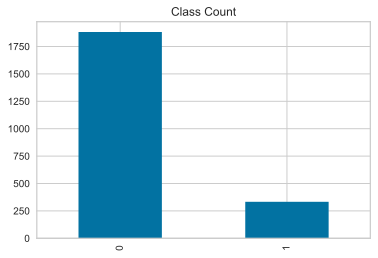

In [209]:
df.Response.value_counts().plot(kind='bar', title= "Class Count");

## Train/test split

In [210]:
y = df['Response']
X = df.drop('Response', axis=1)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=4, stratify=y)

## Resampling-- oversampling minority
- My initial method applies the oversampling to THE WHOLE TRAIN SET
- It should only be applied to train, not val or test
- If we are doing CV within the .8 train set, then we can't oversample the whole .8 train
- Need to oversample train as the CV folds over. This way only the 4/5 train is upsampled, and the 1/5 val within the CV is kept separate. Repate for 5 folds

In [212]:
# KFold to standardize splits
kf = KFold(n_splits=5, random_state=4, shuffle=False)

In [213]:
# # Make pipeline to balance classes. This will be applied into CV methods so that only training set is balanced
# # and the test is not while we fold through 
# imba_pipeline = make_pipeline(SMOTE(random_state=4), \
#                              RandomForestClassifier(n_estimators=100, random_state = 44))
# imba_pipeline

In [214]:
# sorted(sklearn.metrics.SCORERS.keys())

In [215]:
# # CV
# cross_val_score(imba_pipline, X_train, y_train, scoring='f1', cv=kf)

# Begin pipelines
- All based off of imba pipeline that does CV and upsampling in pipe
- With visuals only
- With metrics

In [216]:
# Hyperparams for each of these will be tuned using GridSearchCV later

# Classifiers list for pipeline
classifiers = [KNeighborsClassifier(5),
              GaussianNB(),
              SVC(kernel='rbf', C=.25, probability=True, gamma='auto'),
              DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=100),
              LogisticRegression(solver='lbfgs', max_iter=2000)]


In [217]:
# for classifier in classifiers:
#     test_imba = make_pipeline(SMOTE, classifier)

In [218]:
def pipeline_with_SMOTE(classifiers):
    '''Pipeline that does crossval and balances. Only balances the train part of the CV, not the test.\
    Prints out metrics. This is used for model selection.'''
    for classifier in classifiers:
        pipeline_with_SMOTE = make_pipeline(SMOTE(random_state=4),classifier)
        
        # Print various scoring metrics
        print("Metrics for model: {}".format(classifier))
        print("crossval train accuracy score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring = 'accuracy').mean()))
        print("crossval train recall score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='recall').mean()))
        print("crossval train precision score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='precision').mean()))
        print("crossval train f1 score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='f1').mean()))


In [219]:
pipeline_with_SMOTE(classifiers)

Metrics for model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
crossval train accuracy score: 0.6828391819845627
crossval train recall score: 0.5348517845749183
crossval train precision score: 0.24744354385116582
crossval train f1 score: 0.33672274171787037
Metrics for model: GaussianNB(priors=None, var_smoothing=1e-09)
crossval train accuracy score: 0.7325185008355215
crossval train recall score: 0.5649017865281196
crossval train precision score: 0.29780222626106967
crossval train f1 score: 0.3890249885473175
Metrics for model: SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
crossval train accuracy score: 0.8487626322909205
crossval train recall score: 0.0043478260

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


crossval train precision score: 0.2


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


crossval train f1 score: 0.008510638297872339
Metrics for model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
crossval train accuracy score: 0.8335211267605634
crossval train recall score: 0.5155172077034258
crossval train precision score: 0.4400386655646413
crossval train f1 score: 0.45870206489675514
Metrics for model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                     

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train accuracy score: 0.7793713694596961


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train recall score: 0.769101006549735


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train precision score: 0.3837187265758694


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train f1 score: 0.5100684565281435


In [220]:
def pipeline_with_ADASYN(classifiers):
    '''Pipeline that does crossval and balances. Only balances the train part of the CV, not the test.\
    Prints out metrics. This is used for model selection.'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Print various scoring metrics
        print("Metrics for model: {}".format(classifier))
        print("crossval train accuracy score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring = 'accuracy').mean()))
        print("crossval train recall score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='recall').mean()))
        print("crossval train precision score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='precision').mean()))
        print("crossval train f1 score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='f1').mean()))


In [221]:
pipeline_with_ADASYN(classifiers)

Metrics for model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
crossval train accuracy score: 0.6794557173549773
crossval train recall score: 0.5692056655858952
crossval train precision score: 0.25386285025794153
crossval train f1 score: 0.3489426072834605
Metrics for model: GaussianNB(priors=None, var_smoothing=1e-09)
crossval train accuracy score: 0.7426832179517784
crossval train recall score: 0.586062932145787
crossval train precision score: 0.31341560493128834
crossval train f1 score: 0.40716523306943103
Metrics for model: SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
crossval train accuracy score: 0.7380281690140844
crossval train recall score: 0.19047619047

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


crossval train precision score: 0.03785488958990536


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


crossval train f1 score: 0.06315789473684211
Metrics for model: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
crossval train accuracy score: 0.8244959019654651
crossval train recall score: 0.5062938656457934
crossval train precision score: 0.41173661426293007
crossval train f1 score: 0.4470061012162775
Metrics for model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                      

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train accuracy score: 0.7771194398026577


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train recall score: 0.7550137049624335


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train precision score: 0.38004498358171535


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


crossval train f1 score: 0.5033121701322895


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## ADASYN performed a little better so will use that

In [223]:
def pipeline_with_ADASYN_LCurve(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Learning Curve 
        train_sizes, train_scores, test_scores = learning_curve(pipeline_with_ADASYN, X_train, y_train, cv=kf)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        # Plot Learning Curve
        plt.figure()
        plt.title("plotting learning curve for: {}".format(pipeline_with_ADASYN))
        # if ylim is not None:
        #     plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        plt


KeyboardInterrupt: 

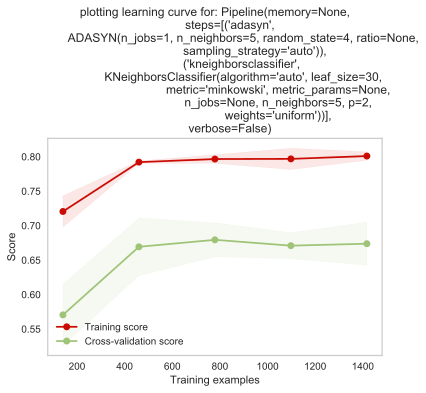

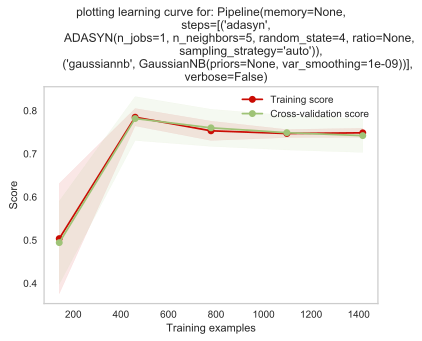

In [224]:
# Below with learning curve for base models
pipeline_with_ADASYN_LCurve(classifiers)

In [225]:
def pipeline_with_ADASYN_PRCurve(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
#         # Precision-Recall Curve Plot
        viz = PrecisionRecallCurve(classifier)
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.show()

#         precision_curve, recall_curve, threshold_curve = precision_recall_curve\
#     (y_test, pipeline_with_SMOTE.predict_proba(X_test)[:,1])
#     plt.figure(dpi=80)
#     plt.plot(threshold_curve, precision_curve[1:],label='precision')
#     plt.plot(threshold_curve, recall_curve[1:], label='recall')
#     plt.legend(loc='lower left')
#     plt.xlabel('Threshold (above this probability, label as fraud)');
#     plt.title('Precision and Recall Curves');

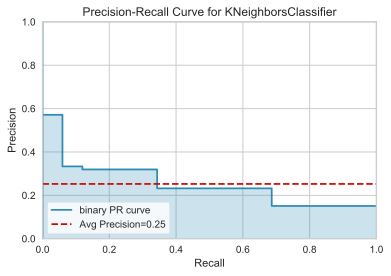

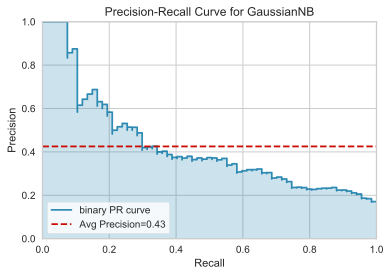

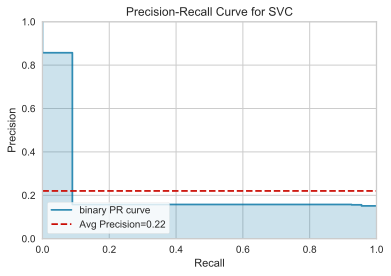

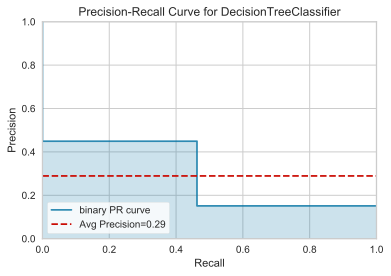

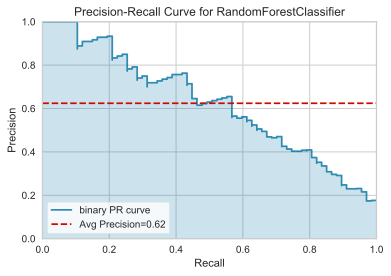

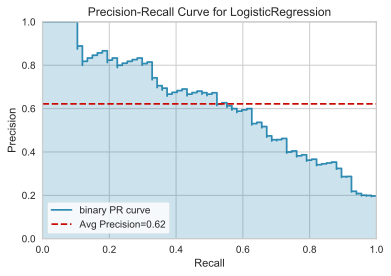

In [226]:
pipeline_with_ADASYN_PRCurve(classifiers)

In [227]:
def pipeline_with_ADASYN_DiscrimThresh(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Discrimination Threshold Plot
        model = pipeline_with_ADASYN
        visualizer = DiscriminationThreshold(model)
        visualizer.fit(X_train, y_train)
        visualizer.show()
        

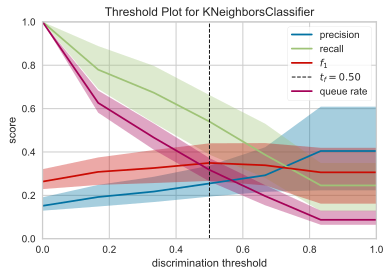

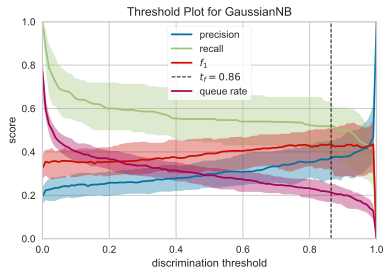

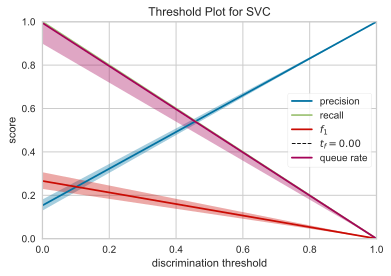

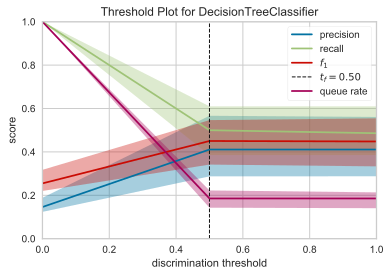

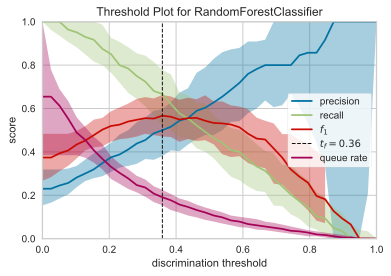

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterati

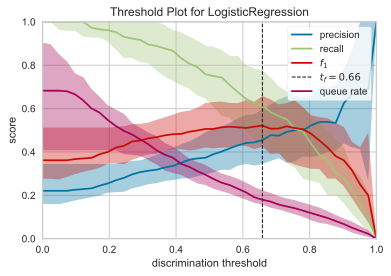

In [228]:
pipeline_with_SMOTE_DiscrimThresh(classifiers)

In [131]:
def pipeline_with_ADASYN_ConfMatrix(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        confusion = confusion_matrix(y_test, pipeline_with_ADASYN.predict(X_test))
        plt.figure(dpi=90)
        ax = sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,\
                   xticklabels=[0,1], yticklabels=[0,1])
        bottom,top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion matrix for: {}'.format(pipeline_with_ADASYN))

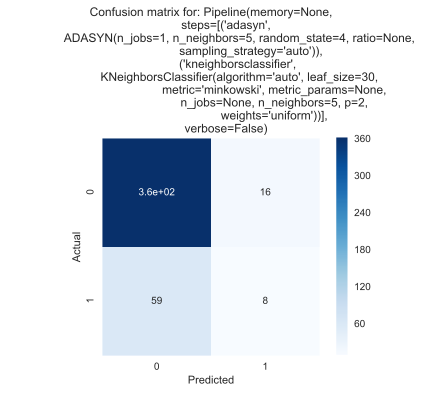

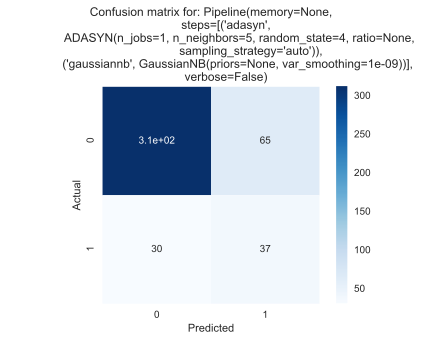

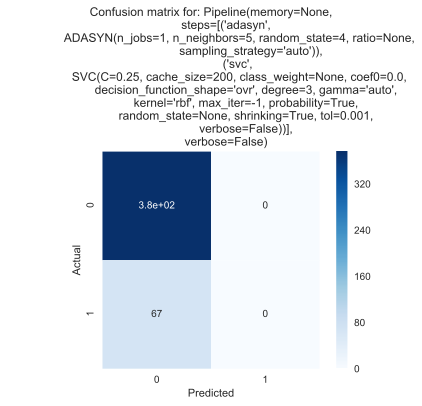

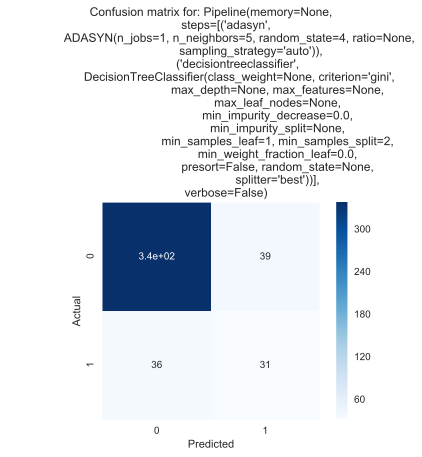

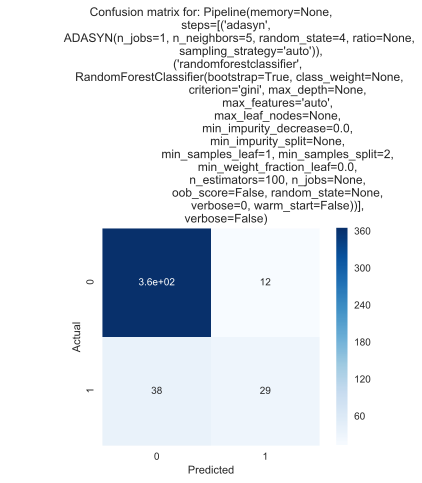

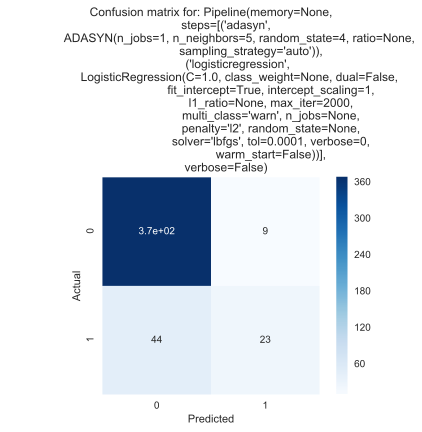

In [229]:
pipeline_with_ADASYN_ConfMatrix(classifiers)

# Grid Search CV on top models: RandomForest + Logistic Regression

In [93]:
top_models = [RandomForestClassifier(),
              LogisticRegression(solver='lbfgs', max_iter=2000)]

## 1. GridSearchCV on RandForest

In [230]:
randforest_pipeline = make_pipeline(ADASYN(random_state=4),RandomForestClassifier())

# Parameters to loop through for RandomForest model
params_randforest = {'n_estimators': [50, 100, 250, 500, 1000, 1500],
          'max_depth': [2, 3],
          'random_state': [4]}

# Prep GridSearchCV
new_params = {'randomforestclassifier__' + key: params_randforest[key] for key in params_randforest}
randforest_pipeline = GridSearchCV(randforest_pipeline, param_grid=new_params, cv=kf, scoring='recall',\
                                   return_train_score=True)

        


In [108]:
randforest_pipeline.fit(X_train, y_train)
print("Random Forest mean test scores: {}".format(randforest_pipeline.cv_results_['mean_test_score']))
print("Random Forest mean train scores: {}".format(randforest_pipeline.cv_results_['mean_train_score']))
print("Random Forest best score: {}".format(randforest_pipeline.best_score_))
print("Random Forest best params: {}".format(randforest_pipeline.best_params_))

Random Forest mean test scores: [0.60951839 0.61187788 0.59943508 0.60278559 0.6129076  0.60933013
 0.59189814 0.58832212 0.59288908 0.56949127 0.57045921 0.57462117]
Random Forest mean train scores: [0.68793591 0.67744649 0.67007601 0.6650006  0.66033564 0.66217051
 0.67911924 0.68365056 0.67504966 0.67320052 0.66481029 0.66584504]
Random Forest best score: 0.6129076034599263
Random Forest best params: {'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__random_state': 4}


In [109]:
# Apply grid search cv results
y_test_predict_randforest = randforest_pipeline.best_estimator_.predict(X_test)
print("Recall for post-gridsearch Random Forest predictions: {}".format(recall_score(y_test, y_test_predict)))

NameError: name 'y_test_predict' is not defined

In [ ]:
Randforest best params: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 4}


## 2. GridSearchCV for LogReg

# ROCAUC for post-gridsearch Random Forest

In [ ]:
# Instantiate the visualizer with the classification model
model = RandomForestClassifier(n_estimators=50, max_depth=6)
visualizer2 = ROCAUC(model, classes=["0", "1"])

visualizer2.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer2.score(X_test, y_test)        # Evaluate the model on the test data
visualizer2.show()                       # Finalize and show the figure

# Manual / nonpipeline loop testing:

# Manual logreg (with imba pipeline, just no loop)

In [97]:
logreg_pipeline = make_pipeline(SMOTE(random_state=4), LogisticRegression(random_state = 44))
logreg_pipeline

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=4, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=44,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [98]:
cross_val_score(logreg_pipeline, X_train,y_train, scoring='recall', cv=kf)

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

array([0.62264151, 0.73214286, 0.77083333, 0.7826087 , 0.71428571])

In [99]:
logreg_pipeline.fit(X_train,y_train)

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=4, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=44,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [100]:
y_predict_logreg = logreg_pipeline.predict(X_test)

# Predict_proba for logreg_pipeline (imbalearn implemented)

In [101]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, logreg_pipeline.predict_proba(X_train)[:,1] )
df_logreg_pipe = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),\
                     columns=['precision','recall', 'threshhold'])

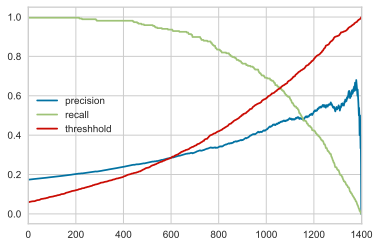

In [102]:
df_logreg_pipe.plot()

# Test XGBoost-- poor performance because not upsampled yet

In [232]:
xg_reg = xgb.XGBClassifier()
xg_reg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [233]:
y_pred = xg_reg.predict(X_test)
predictions = [round(value) for value in y_pred]

In [234]:
# CV xgboost
params = {}
# params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}
# Params is a dict of booster/testers
cv_results = xgb.cv(dtrain=data_dmatrix, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='recall',\
                   as_pandas=True, seed=123)

NameError: name 'data_dmatrix' is not defined

In [ ]:
accuracy = accuracy_score(y_test,predictions)
recall = recall_score(y_test,predictions)
print("Accuracy is: {}".format(accuracy))
print("Recall is: {}".format(recall))

In [ ]:
xgb.plot_importance(xg_reg)

## Test precision recall curve for LR manually

In [ ]:
# from sklearn.metrics import precision_recall_curve
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# print("Test set score is {}%".format(100*logreg.score(X_test,y_test)))

# # Metrics for LogReg
# y_predict_randforest = logreg.predict(X_test)

# precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1] )

# df_pr = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),
#               columns=['precision','recall', 'threshhold'])
# # print("Random Forest Metrics on Test data:")
# # print("Accuracy is: {}".format(accuracy_score(y_test,y_predict_randforest)))
# # print("Precision is: {}".format(precision_score(y_test,y_predict_randforest)))
# # print("Recall is: {}".format(recall_score(y_test,y_predict_randforest)))
# # print("F1 is: {}".format(f1_score(y_test,y_predict_randforest)))

In [ ]:
# df_pr

In [ ]:
# df_pr.plot()

In [ ]:
# precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1] )

## Testing learning curve + plot for random forest, outside of pipeline loop

In [ ]:
randforest = RandomForestClassifier(n_estimators=100)
randforest.fit(X_train, y_train)
print("Test set score is {}%".format(100*randforest.score(X_test,y_test)))

In [ ]:
# Random Forest cross val score
print(cross_val_score(randforest,X_train,y_train,cv=5).mean())

In [ ]:
# Metrics for Random Forest
y_predict_randforest = randforest.predict(X_test)
print("Random Forest Metrics on Test data:")
print("Accuracy is: {}".format(accuracy_score(y_test,y_predict_randforest)))
print("Precision is: {}".format(precision_score(y_test,y_predict_randforest)))
print("Recall is: {}".format(recall_score(y_test,y_predict_randforest)))
print("F1 is: {}".format(f1_score(y_test,y_predict_randforest)))

In [ ]:
train_sizes2, train_scores2, test_scores2 = learning_curve(
        randforest, X_train, y_train, cv=5)

train_scores_mean2 = np.mean(train_scores2, axis=1)
train_scores_std2 = np.std(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
test_scores_std2 = np.std(test_scores2, axis=1)

plt.figure()
plt.title("plotting learning curve")
# if ylim is not None:
#     plt.ylim(*ylim)
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes2, train_scores_mean2 - train_scores_std2,
                    train_scores_mean2 + train_scores_std2, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes2, test_scores_mean2 - test_scores_std2,
                    test_scores_mean2 + test_scores_std2, alpha=0.1, color="g")
plt.plot(train_sizes2, train_scores_mean2, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes2, test_scores_mean2, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")
plt

## Add a plot with toy data to illustrate point that growth % is stagnant and we need a new marketing strategy

In [3]:
import pandas as pd


In [17]:
df_toy = pd.DataFrame({
    'Quarter':['18Q1','18Q2', '18Q3', '18Q4', '19Q1', '19Q2', '19Q3'],
    'Percent Growth':[5,7,12,9,10,5,5]
})

# MAKE THIS IN MATPLOTLIB / SNS + make better

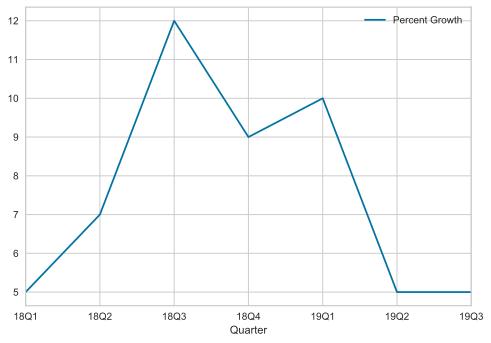

In [18]:
df_toy.plot(kind='line',x='Quarter',y='Percent Growth')

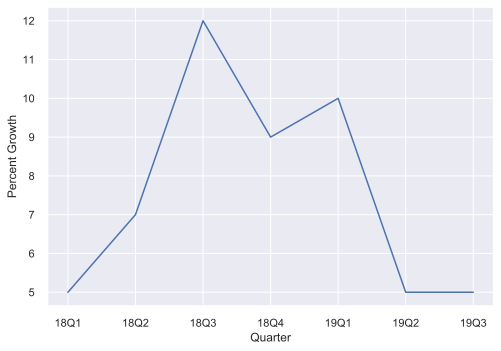

In [25]:
sns.set(style="darkgrid")
ax = sns.lineplot(x="Quarter", y="Percent Growth", data=df_toy)

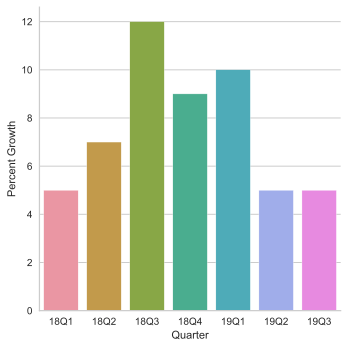

In [23]:
sns.set_style("whitegrid")
sns.catplot(x="Quarter", y="Percent Growth",
            kind="bar", data=df_toy);